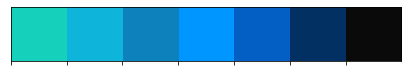

In [1]:
## Improt python libraries 
import time  
import numpy as np  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt 
%matplotlib inline

import os, sys, io
import requests
from zipfile import ZipFile
import datetime as dt

## Set custom palette color for diagram
custom_palette = sns.color_palette(["#15d1bb","#0fb4db","#0d81bb","#0096ff","#045fc4","#023062","#0a0a0a"])
sns.palplot(custom_palette)
sns.set_palette(custom_palette)
figure_size = (9,5)

In [2]:
## Function to get bluebike data from s3 bucket 
## Source: https://s3.amazonaws.com/hubway-data/index.html

def getData(begin_year=2021, end_year=2021):

  csv_list = list()
  for year in range(begin_year, end_year + 1):

    for month in range(1,13):
      # since 2018 the company name was changes to bluebike, originally was hubway
      filename = 'hubway' 
      if (year == 2018 and month > 4) or (year > 2018):
            filename = 'bluebikes'
          
      if month < 10: 
        month = str('0' + str(month))
      else:
        month = str(month)
      
      csv_name = '{}{}-{}-tripdata'.format(str(year), month, filename)
      csv_list.append(csv_name)

  output_file = 'bluebikes_tripdata_{}_{}.csv'.format(begin_year, end_year)
  if not os.path.exists(output_file):

      is_header = True
      for csv_name in csv_list:
        zip_file = 'https://s3.amazonaws.com/hubway-data/{}.zip'.format(csv_name)
        try:
          # load data with io/stream directly from internet url 
          load = pd.read_csv(zip_file, dtype = str, chunksize=10000)
        except:
          # in case it is not possible, download it first and then load
          response = requests.get(zip_file)
          zip = ZipFile(io.BytesIO(response.content))
          with zip.open('{}.csv'.format(csv_name), mode="r") as csv_file:
              load = [pd.read_csv(csv_file)]

        # load data into one csv file
        for df in load:
          df.to_csv(output_file, mode='a', index=False, header=is_header)
          if is_header:
              is_header = False
  return pd.read_csv(output_file, index_col=False, dtype='unicode')

In [3]:
## Get data from 2015 to 2021
bluebikes = getData(begin_year=2015, end_year=2021)
bluebikes.describe()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
count,12970938,12970938,12970938,12970938,12970938,12970938,12970938,12970938,12970938,12970938,12970938,12970938,12970938,12595044,8379088
unique,46617,12786574,12781939,493,651,740,698,493,654,742,700,7064,2,14802,3
top,393,2017-08-04 08:54:42,2017-08-15 17:37:49,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,277,Subscriber,\N,1
freq,13731,6,6,321760,321760,321760,321760,312909,312909,312909,312909,4673,9864688,680978,5321440


In [4]:
## Cleanup data, and drop some columns
bluebikes = bluebikes.drop(columns=['start station latitude', 'start station longitude', 'start station id', 'end station latitude', 'end station longitude', 'end station id'])
bluebikes[bluebikes.isnull().any(axis=1)].head()

,tripduration,starttime,stoptime,start station name,end station name,bikeid,usertype,birth year,gender
3672609,1376,2018-01-01 13:24:07,2018-01-01 13:47:03,Charles Circle - Charles St at Cambridge St TE...,Charles Circle - Charles St at Cambridge St TE...,1781,Customer,NaN,0
3672610,1366,2018-01-01 13:24:11,2018-01-01 13:46:57,Charles Circle - Charles St at Cambridge St TE...,Charles Circle - Charles St at Cambridge St TE...,5,Customer,NaN,0
3672745,575,2018-01-02 07:17:30,2018-01-02 07:27:05,Charles Circle - Charles St at Cambridge St TE...,Back Bay T Stop - Dartmouth St at Stuart St,5,Customer,NaN,0
3672786,1696,2018-01-02 07:54:45,2018-01-02 08:23:02,Nashua Street at Red Auerbach Way,Sidney Research Campus/ Erie Street at Waverly,1082,Customer,NaN,0
3672951,572,2018-01-02 10:54:04,2018-01-02 11:03:36,Packard's Corner - Commonwealth Ave at Brighto...,HMS/HSPH - Avenue Louis Pasteur at Longwood Ave,1824,Subscriber,NaN,0


In [5]:
## Convert to datetime
bluebikes['starttime'] = pd.to_datetime(bluebikes['starttime'])
bluebikes['stoptime'] = pd.to_datetime(bluebikes['stoptime'])

## Convert to string
bluebikes['start station name'] = bluebikes['start station name'].astype('string')
bluebikes['end station name'] = bluebikes['end station name'].astype('string')

## Convert to category
bluebikes['usertype'] = bluebikes['usertype'].astype('category')
bluebikes = bluebikes.rename({'usertype': 'Usertype'}, axis='columns')
bluebikes['gender'] = bluebikes['gender'].astype('category')

## Convert to numeric
bluebikes['tripduration'] = pd.to_numeric(bluebikes['tripduration'])

In [6]:
## Add columns for the year, month, day, hour
bluebikes['Year'] = bluebikes.starttime.dt.year
bluebikes['month'] = bluebikes.starttime.dt.month
bluebikes['day'] = (bluebikes.starttime.dt.dayofweek)+1 # +1 to make Monday=1 and Sunday=7
bluebikes['Hour'] = bluebikes.starttime.dt.hour

In [7]:
## Convert day to readable 
def toDayWord(day):
   dayWord = {1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun"}
   return dayWord[day]

bluebikes['Day'] = bluebikes['day'].apply(toDayWord)
day_order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

In [8]:
## Concert month to readable
def toMonthWord(month):
    monthWord = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
    return monthWord[month]

bluebikes['Month'] = bluebikes['month'].apply(toMonthWord)
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

In [9]:
## Convert tripduration to minutes and add as new column
def convertToMinute(seconds):
    min, sec = divmod(seconds, 60)
    if sec > 30:
      min += 1
    return min

bluebikes['Duration'] = bluebikes['tripduration'].apply(convertToMinute)

In [10]:
## Add weekday/weekend column
def convertToWeekTime(day):
    if day <= 5:
      return 'Weekday'
    else:
      return 'Weekend'

bluebikes['Week'] = bluebikes['day'].apply(convertToWeekTime)

In [11]:
## Sorting Columns
bluebikes = bluebikes.loc[:, ['bikeid','starttime','stoptime','start station name','end station name','Usertype','birth year','gender','tripduration','Duration','Hour','day','Day','Week','month','Month','Year']]
bluebikes.head()

,bikeid,starttime,stoptime,start station name,end station name,Usertype,birth year,gender,tripduration,Duration,Hour,day,Day,Week,month,Month,Year
0,277,2015-01-01 00:21:44,2015-01-01 00:30:47,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,Subscriber,1984,1,542,9,0,4,Thu,Weekday,1,Jan,2015
1,648,2015-01-01 00:27:03,2015-01-01 00:34:21,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,Subscriber,1985,1,438,7,0,4,Thu,Weekday,1,Jan,2015
2,555,2015-01-01 00:31:31,2015-01-01 00:35:46,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,Subscriber,1974,1,254,4,0,4,Thu,Weekday,1,Jan,2015
3,1307,2015-01-01 00:53:46,2015-01-01 01:00:58,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,Subscriber,1987,1,432,7,0,4,Thu,Weekday,1,Jan,2015
4,177,2015-01-01 01:07:06,2015-01-01 01:19:21,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,Customer,1986,2,735,12,1,4,Thu,Weekday,1,Jan,2015


In [12]:
## Show all data types
bluebikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970938 entries, 0 to 12970937
Data columns (total 17 columns):
 #   Column              Dtype         
---  ------              -----         
 0   bikeid              object        
 1   starttime           datetime64[ns]
 2   stoptime            datetime64[ns]
 3   start station name  string        
 4   end station name    string        
 5   Usertype            category      
 6   birth year          object        
 7   gender              category      
 8   tripduration        int64         
 9   Duration            int64         
 10  Hour                int64         
 11  day                 int64         
 12  Day                 object        
 13  Week                object        
 14  month               int64         
 15  Month               object        
 16  Year                int64         
dtypes: category(2), datetime64[ns](2), int64(6), object(5), string(2)
memory usage: 1.5+ GB


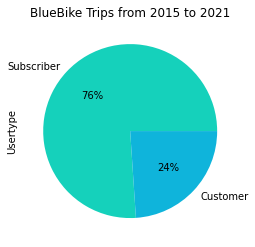

In [13]:
## Ratio of Subscribers to Customers | 2015 - 2021
fig = bluebikes['Usertype'].value_counts().plot(kind='pie', label='Usertype', autopct='%1.0f%%', title='BlueBike Trips from 2015 to 2021')

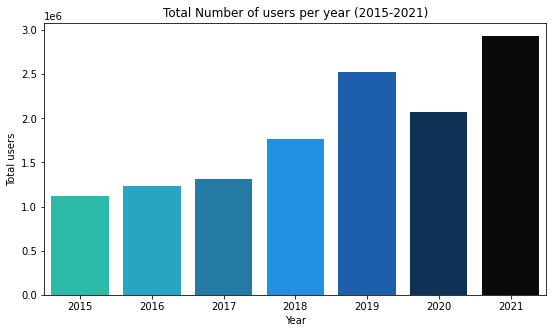

In [14]:
## Total No. of rides per year  | 2015 - 2021
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(data=bluebikes, x="Year").set(title='Total Number of users per year (2015-2021)', xlabel='Year', ylabel='Total users')

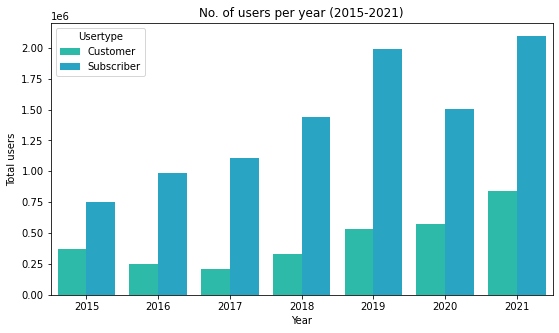

In [15]:
## No. of rides per year (Subscriber/Customer) | 2015 - 2021
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(data=bluebikes, x="Year", hue="Usertype").set(title='No. of users per year (2015-2021)', xlabel='Year', ylabel='Total users')

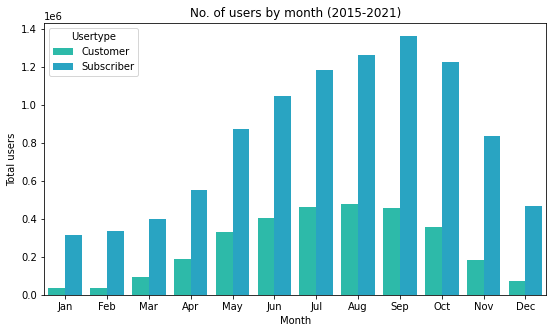

In [16]:
## No. of users by Month (Subscriber/Customer) | 2015 - 2021
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(data=bluebikes, x="Month", hue="Usertype", order=month_order).set(title='No. of users by month (2015-2021)', xlabel='Month', ylabel='Total users')

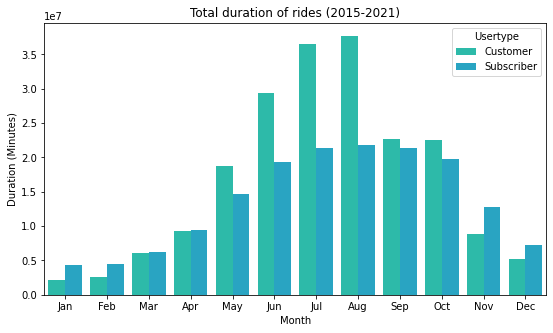

In [17]:
## Total duration of rides per month (Subscriber/Customer) | 2015 - 2021
bike_time = bluebikes.groupby([bluebikes['Month'], bluebikes['Usertype']]).Duration.sum().reset_index()

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.barplot(x='Month', y='Duration', data=bike_time, hue="Usertype", order=month_order).set(title='Total duration of rides (2015-2021)', xlabel='Month', ylabel='Duration (Minutes)')
del bike_time

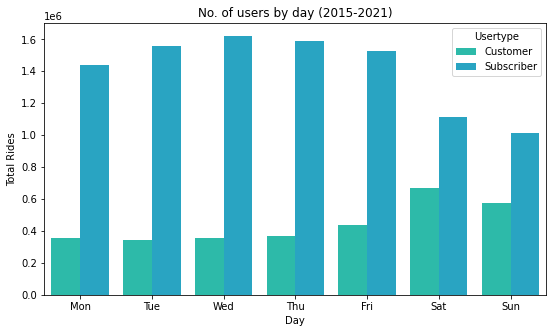

In [18]:
# No. of users by day (Subscriber/Customer) | 2015 - 2021
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(x='Day', data=bluebikes, hue="Usertype", order=day_order).set(title='No. of users by day (2015-2021)', xlabel='Day', ylabel='Total Rides')

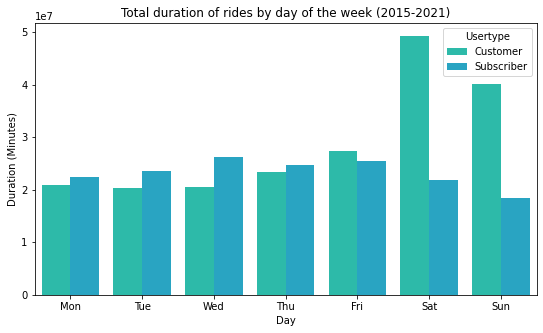

In [19]:
# Total duration by day of the week | 2015 - 2021
bike_time_duration = bluebikes.groupby([bluebikes['Day'], bluebikes['Usertype']]).Duration.sum().reset_index()

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.barplot(x='Day', y='Duration', data=bike_time_duration, hue="Usertype", order=day_order).set(title='Total duration of rides by day of the week (2015-2021)', xlabel='Day', ylabel='Duration (Minutes)')
del bike_time_duration

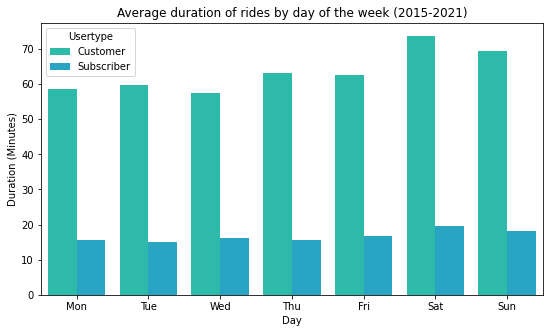

In [20]:
## Average duration by day of the week (Subscriber/Customer) | 2015 - 2021
bike_time_average = bluebikes.groupby([bluebikes['Day'], bluebikes['Usertype']]).Duration.mean().reset_index()

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.barplot(x='Day', y='Duration', data=bike_time_average, hue="Usertype", order=day_order).set(title='Average duration of rides by day of the week (2015-2021)', xlabel='Day', ylabel='Duration (Minutes)')
del bike_time_average

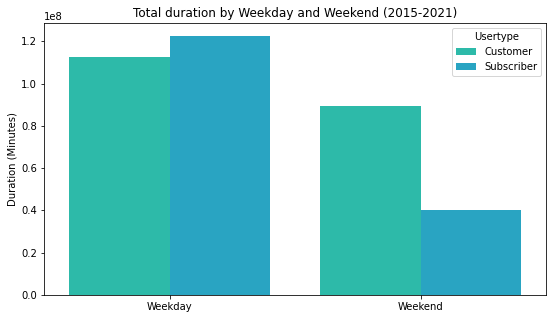

In [21]:
## Total duration by weekday/weekend (Subscriber/Customer) | 2015 - 2021
weekday_total = bluebikes.groupby([bluebikes['Week'], bluebikes['Usertype']]).Duration.sum().reset_index()

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.barplot(x='Week', y='Duration', data=weekday_total, hue="Usertype").set(title='Total duration by Weekday and Weekend (2015-2021)', xlabel=None, ylabel='Duration (Minutes)')
del weekday_total

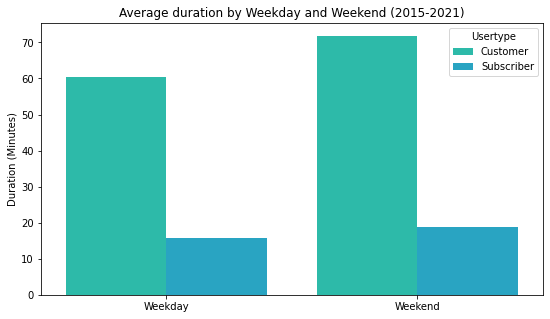

In [22]:
## Average duration by weekday/weekend (Subscriber/Customer) | 2015 - 2021
weekday_average = bluebikes.groupby([bluebikes['Week'], bluebikes['Usertype']]).Duration.mean().reset_index()

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.barplot(x='Week', y='Duration', data=weekday_average, hue="Usertype").set(title='Average duration by Weekday and Weekend (2015-2021)', xlabel=None, ylabel='Duration (Minutes)')
del weekday_average

[Text(0, 0.5, 'Total User Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Total User Count By Hour Of The Day Across Week (2015-2021)'),
 None]

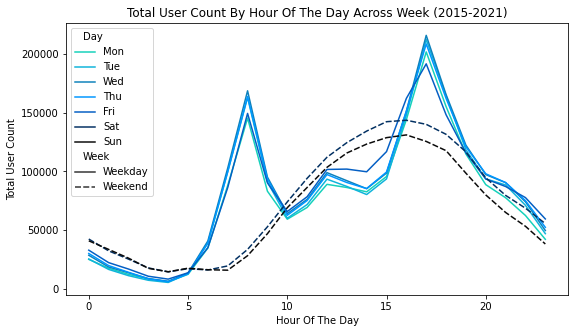

In [23]:
## Users Count By Hour Of The Day Across Weekdays (Accumulation] | 2015 - 2021
average_user_per_hour = bluebikes.groupby([bluebikes['Hour'], bluebikes['day']]).starttime.count().reset_index()
average_user_per_hour = average_user_per_hour.rename({'starttime': 'count'}, axis='columns')
average_user_per_hour['Day'] = average_user_per_hour['day'].apply(toDayWord)
average_user_per_hour['Week'] = average_user_per_hour['day'].apply(convertToWeekTime)

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.lineplot(x="Hour", y="count", data=average_user_per_hour, hue='Day', style='Week', palette=custom_palette)
fig.set(xlabel='Hour Of The Day', ylabel='Total User Count',title="Total User Count By Hour Of The Day Across Week (2015-2021)",label='big')

In [24]:
## Maximum numner of total ride in a day | 2015 - 2021
average_user_per_hour['count'].max()

216096

In [25]:
## Show information of the day for the maximum numner
average_user_per_hour.loc[average_user_per_hour['count']==216096]

,Hour,day,count,Day,Week
121,17,3,216096,Wed,Weekday


In [26]:
## Minimum numner of total ride in a day | 2015 - 2021
average_user_per_hour['count'].min()

5228

In [27]:
## Show information of the day for the minimum numner
average_user_per_hour.loc[average_user_per_hour['count']==5228]

,Hour,day,count,Day,Week
29,4,2,5228,Tue,Weekday


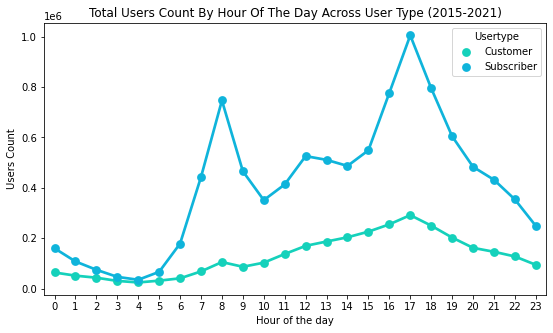

In [28]:
## Users Count By Hour Of The Day Across User Type (Subscriber/Customer) | 2015 - 2021
user_per_hour = bluebikes.groupby([bluebikes['Hour'], bluebikes['Usertype']]).starttime.count().reset_index()
user_per_hour = user_per_hour.rename({'starttime': 'count'}, axis='columns')

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.pointplot(x="Hour", y= "count", data= user_per_hour, hue='Usertype', join=True).set(xlabel='Hour of the day', ylabel='Users Count',title="Total Users Count By Hour Of The Day Across User Type (2015-2021)",label='big')
del user_per_hour

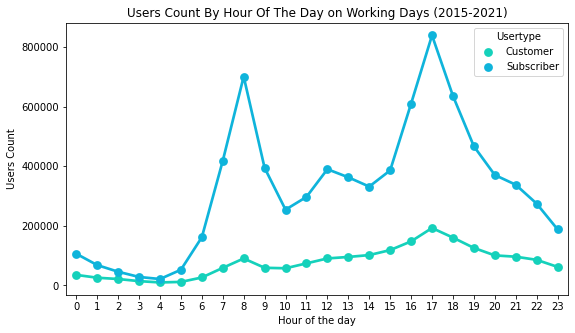

In [29]:
## Average Users Count By Hour Of The Day Across Days of the week per user type --> Working Days Only (Subscriber/Customer) | 2015 - 2021
bluebikesworkingday = bluebikes.loc[bluebikes["day"] < 6]
bluebikesworkingday = bluebikesworkingday.groupby([bluebikesworkingday['Hour'], bluebikesworkingday['Usertype']]).starttime.count().reset_index()
bluebikesworkingday = bluebikesworkingday.rename({'starttime': 'count'}, axis='columns')

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.pointplot(x="Hour", y= "count", data= bluebikesworkingday, hue='Usertype', join=True).set(xlabel='Hour of the day', ylabel='Users Count',title="Users Count By Hour Of The Day on Working Days (2015-2021)",label='big')
del bluebikesworkingday

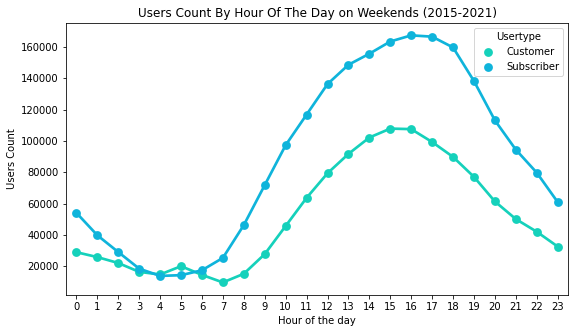

In [30]:
## Average Users Count By Hour Of The Day Across Days of the week per user type --> Weekends Only (Subscriber/Customer) | 2015 - 2021
bluebikesweekend = bluebikes.loc[bluebikes["day"] > 5]
bluebikesweekend = bluebikesweekend.groupby([bluebikesweekend['Hour'], bluebikesweekend['Usertype']]).starttime.count().reset_index()
bluebikesweekend = bluebikesweekend.rename({'starttime': 'count'}, axis='columns')

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.pointplot(x="Hour", y= "count", data= bluebikesweekend, hue='Usertype', join=True).set(xlabel='Hour of the day', ylabel='Users Count',title="Users Count By Hour Of The Day on Weekends (2015-2021)",label='big')
del bluebikesweekend

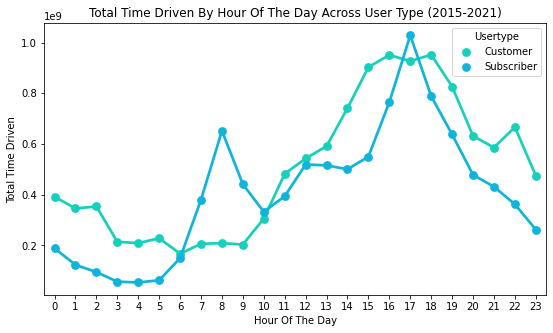

In [31]:
## Total Time Driven By Hour Of The Day Across User Type (Subscriber/Customer) | 2015 - 2021
total_tripduration = bluebikes.groupby([bluebikes['Hour'], bluebikes['Usertype']]).tripduration.sum().reset_index()

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.pointplot(x="Hour", y= "tripduration", data= total_tripduration, hue='Usertype', join=True).set(xlabel='Hour Of The Day', ylabel='Total Time Driven',title="Total Time Driven By Hour Of The Day Across User Type (2015-2021)",label='big')
del total_tripduration

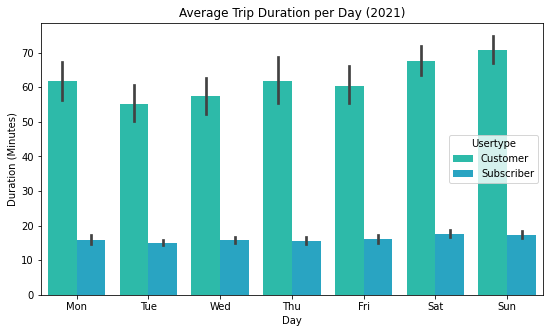

In [32]:
## Mean value average per day | 2021
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.barplot(data=bluebikes[bluebikes['Year']==2021], x="Day", y="Duration", hue="Usertype", order=day_order).set(xlabel='Day', ylabel='Duration (Minutes)',title="Average Trip Duration per Day (2021)")

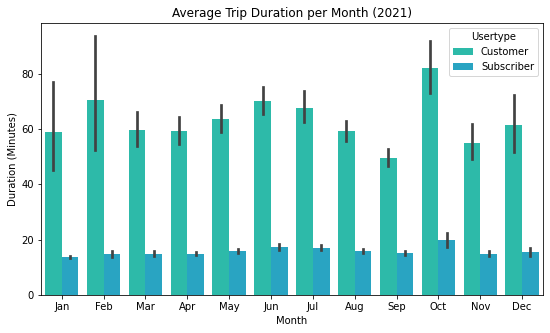

In [33]:
## Mean value average per day | 2021
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.barplot(data=bluebikes[bluebikes['Year']==2021], x="Month", y="Duration", hue="Usertype", order=month_order).set(xlabel='Month', ylabel='Duration (Minutes)',title="Average Trip Duration per Month (2021)")

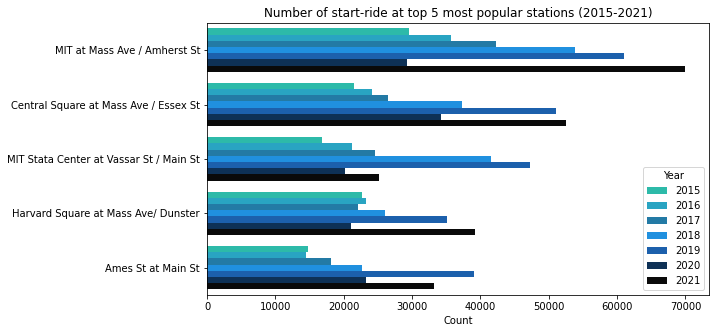

In [34]:
## Top 5 start-stations where bike were taken
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(data=bluebikes, y="start station name", hue='Year', order=bluebikes['start station name'].value_counts().iloc[:5].index, palette=custom_palette).set(xlabel='Count', ylabel=None,title="Number of start-ride at top 5 most popular stations (2015-2021)")

In [35]:
## Show how many bike were taken from the MIT at Mass Ave / Amherst St in 6 years | 2015 - 2021 
bluebikes[bluebikes['start station name']=='MIT at Mass Ave / Amherst St'].count()

bikeid                321760
starttime             321760
stoptime              321760
start station name    321760
end station name      321760
Usertype              321760
birth year            317982
gender                232290
tripduration          321760
Duration              321760
Hour                  321760
day                   321760
Day                   321760
Week                  321760
month                 321760
Month                 321760
Year                  321760
dtype: int64

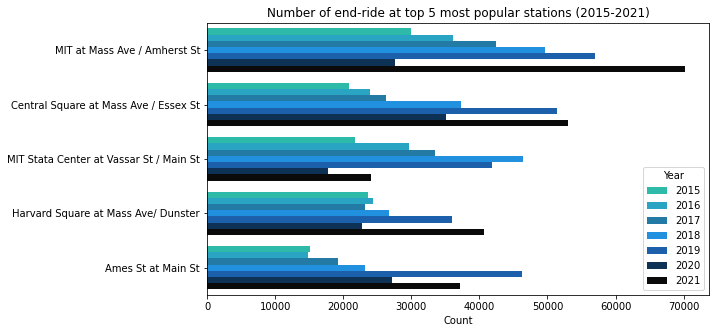

In [36]:
## Top 5 end-stations where bike were put back
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(data=bluebikes, y="end station name", hue='Year', order=bluebikes['end station name'].value_counts().iloc[:5].index, palette=custom_palette).set(xlabel='Count', ylabel=None,title="Number of end-ride at top 5 most popular stations (2015-2021)")

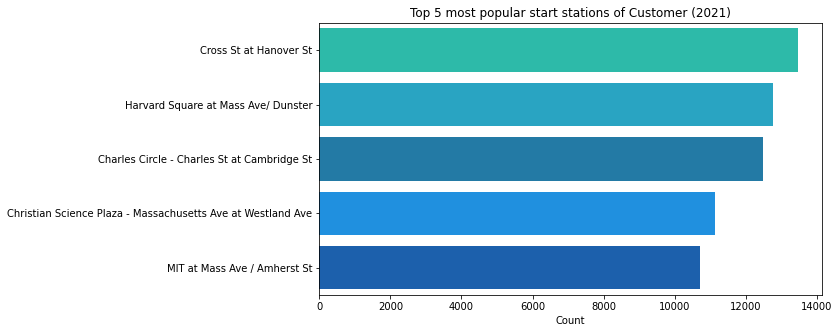

In [37]:
## Top 5 start-stations for customer | 2021
bluebikes_customer_2021 = bluebikes[(bluebikes['Usertype']=='Customer')&(bluebikes['Year']==2021)]

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(data=bluebikes_customer_2021, y="start station name", order=bluebikes_customer_2021['start station name'].value_counts().iloc[:5].index, palette=custom_palette).set(xlabel='Count', ylabel=None,title="Top 5 most popular start stations of Customer (2021)")

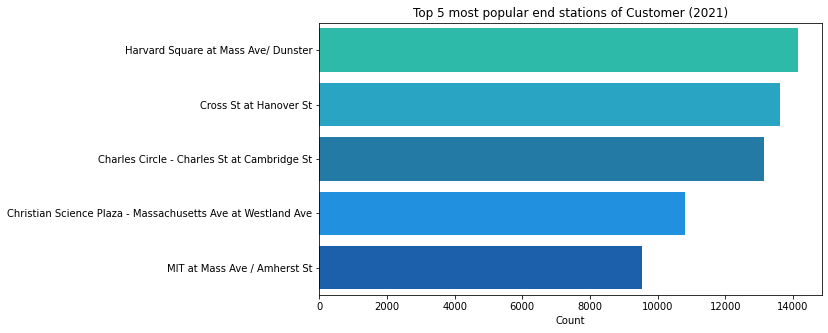

In [38]:
## Top 5 end-stations of customer | 2021
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(data=bluebikes_customer_2021, y="end station name", order=bluebikes_customer_2021['end station name'].value_counts().iloc[:5].index, palette=custom_palette).set(xlabel='Count', ylabel=None,title="Top 5 most popular end stations of Customer (2021)")
del bluebikes_customer_2021

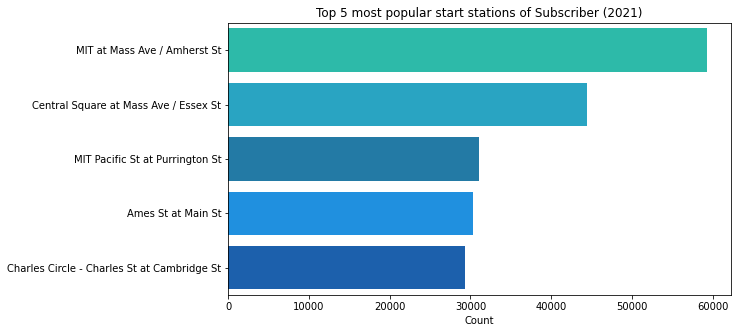

In [39]:
## Top 5 start-stations of subscriber | 2021
bluebikes_subscriber_2021 = bluebikes[(bluebikes['Usertype']=='Subscriber')&(bluebikes['Year']==2021)]

fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(data=bluebikes_subscriber_2021, y="start station name", order=bluebikes_subscriber_2021['start station name'].value_counts().iloc[:5].index, palette=custom_palette).set(xlabel='Count', ylabel=None,title="Top 5 most popular start stations of Subscriber (2021)")

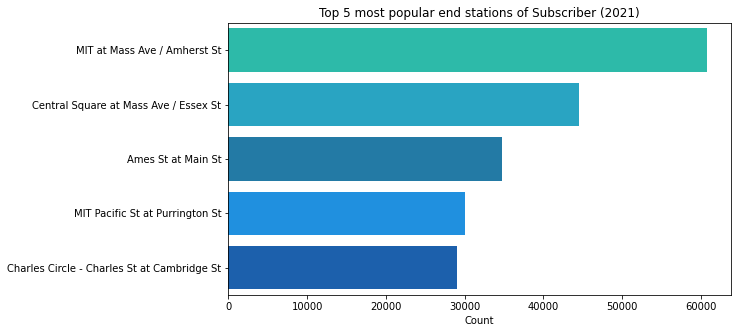

In [40]:
## Top 5 end-stations of subscriber | 2021
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(data=bluebikes_subscriber_2021, y="end station name", order=bluebikes_subscriber_2021['end station name'].value_counts().iloc[:5].index, palette=custom_palette).set(xlabel='Count', ylabel=None,title="Top 5 most popular end stations of Subscriber (2021)")
del bluebikes_subscriber_2021

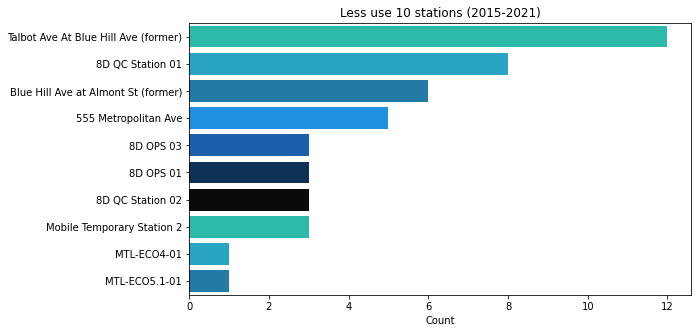

In [41]:
## Less used 10 stations | 2015 - 2021 
fig, ax = plt.subplots(figsize=figure_size)
fig = sns.countplot(data=bluebikes, y="start station name", order=bluebikes['start station name'].value_counts().iloc[-10:].index, palette=custom_palette).set(xlabel='Count', ylabel=None,title="Less use 10 stations (2015-2021)")

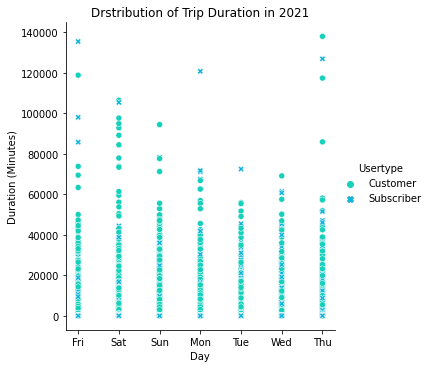

In [42]:
# Show trip duration distribution | 2021
sns.relplot(data=bluebikes[bluebikes['Year']==2021], x="Day", y="Duration", hue="Usertype", style="Usertype").set(xlabel='Day', ylabel='Duration (Minutes)',title="Drstribution of Trip Duration in 2021")